#### Table of Contents
[1. Import Libraries](#s1)<br/>
[2. Load Data](#s2)<br/>
[3. Exploratory Data Analysis](#s3)<br/>
[4. Problem Definition](#s4)<br/>
[5. Data Preparation](#s5)<br/>
[6. Train Model](#s6)<br/>
[7. Model Evaluation](#s7)<br/>
[8. Experiment](#s8)<br/>
[9. Reference](#s9)<br/>





## 🔄 Import Libraries<a class="anchor"  id="s1"></a>

In [1]:
# Input files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


# Import libraries 
from sklearn.model_selection import train_test_split,cross_validate
from skmultilearn.problem_transform import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import VotingClassifier,GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier,HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np 
import pandas as pd
from scipy.stats import ks_2samp

# Configure number format
pd.set_option('display.float_format', '{:,.3f}'.format)

# Remove warning
import warnings
warnings.simplefilter('ignore')

# Constant
RANDOM_STATE = 42

/kaggle/input/playground-series-s3e18/sample_submission.csv
/kaggle/input/playground-series-s3e18/train.csv
/kaggle/input/playground-series-s3e18/test.csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 📚 Load Data<a class="anchor"  id="s2"></a>

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e18/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s3e18/test.csv")
df_submission = pd.read_csv("/kaggle/input/playground-series-s3e18/sample_submission.csv")
X_submission = df_test.copy().drop(columns=['id'])

display(df_train.sample(3))
display(df_test.sample(3))
display(df_submission.sample(3))

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
6917,6917,162.638,4.664,2.442,3.975,1.605,2.891,1.292,0.363,6.104,...,0.000,25.578,0,0,1,1,0,0,0,0
60,60,59.814,4.037,2.281,2.281,1.623,1.623,0.357,0.000,5.969,...,4.795,21.333,1,1,1,1,0,1,0,0
5652,5652,"1,337.359",20.352,12.482,15.472,9.507,12.504,8.841,4.508,89.250,...,31.962,79.286,0,0,0,1,1,0,0,0


,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
2505,17343,201.374,5.365,2.797,4.318,1.817,2.860,1.113,0.346,7.823,...,7.823,0.000,0.000,0.000,7.823,6.166,9.089,25.089,0,0
5256,20094,"1,101.893",22.532,18.048,18.048,14.631,14.631,10.323,6.523,86.316,...,119.568,13.847,0.000,0.000,11.859,173.576,36.756,120.667,0,0
2856,17694,633.325,11.528,8.990,8.990,6.812,6.812,5.153,3.359,0.000,...,0.000,18.209,23.772,11.836,0.000,12.208,4.737,48.333,0,0


,id,EC1,EC2
2056,16894,0.500,0.500
2905,17743,0.500,0.500
2891,17729,0.500,0.500


## 🔍 Exploratory Data Analysis<a class="anchor"  id="s3"></a>
`1` Within the training data, i'm interested to check **data cleanliness** which includes missing values/ completeness, distinct values, duplication, data-types, skewness, and class balances to name a few. These information can simply derived from the `describe` function. Quick note, before doing, so I feel like it's important to ensure <mark> data types are correct and duplications are checked </mark> otherwise the conclusion can be misleading. <br/><br/>
`2` I'm also interested to see **important features** trough feature-importance from `RandomForest`, as well as the `correlation` value. This helps to focus the effort when engineering features (if needed) <mark>to allocate effort to the features that relative has higher importance.</mark> <br/><br/>
`3` Finally, I wanted to check the **distribution between test and training** using use `Kolmogorof` test statistics <mark>to gauge how the model would perform</mark>. And if there're features that visibly skewed between train and test, we can just remove it from the predictors rather than affecting the model performance. 

### Data Cleanliness

In [3]:
# Check for duplicates
print('Data duplication')
print('Duplicated rows: {}'.format(df_train.duplicated().sum()))

# Check for types
print('\nData type')
print(df_train.dtypes)

# Check for data imbalance
print('\nClass balance')
display(pd.concat([df_train["EC1"].value_counts(),df_train["EC1"].value_counts(normalize=True)], axis = 1, keys = ["Count","Pct"] ))
display(pd.concat([df_train["EC2"].value_counts(),df_train["EC2"].value_counts(normalize=True)], axis = 1, keys = ["Count","Pct"] ))

# Check for distinct value
print('\nDistinct values')
display(df_train.nunique())

Data duplication
Duplicated rows: 0

Data type
id                     int64
BertzCT              float64
Chi1                 float64
Chi1n                float64
Chi1v                float64
Chi2n                float64
Chi2v                float64
Chi3v                float64
Chi4n                float64
EState_VSA1          float64
EState_VSA2          float64
ExactMolWt           float64
FpDensityMorgan1     float64
FpDensityMorgan2     float64
FpDensityMorgan3     float64
HallKierAlpha        float64
HeavyAtomMolWt       float64
Kappa3               float64
MaxAbsEStateIndex    float64
MinEStateIndex       float64
NumHeteroatoms         int64
PEOE_VSA10           float64
PEOE_VSA14           float64
PEOE_VSA6            float64
PEOE_VSA7            float64
PEOE_VSA8            float64
SMR_VSA10            float64
SMR_VSA5             float64
SlogP_VSA3           float64
VSA_EState9          float64
fr_COO                 int64
fr_COO2                int64
EC1                    in

,Count,Pct
1,9908,0.668
0,4930,0.332


,Count,Pct
1,11855,0.799
0,2983,0.201



Distinct values


id                   14838
BertzCT               2368
Chi1                  1259
Chi1n                 3157
Chi1v                 3306
Chi2n                 3634
Chi2v                 3725
Chi3v                 3448
Chi4n                 2930
EState_VSA1            719
EState_VSA2            445
ExactMolWt            1666
FpDensityMorgan1       556
FpDensityMorgan2       650
FpDensityMorgan3       654
HallKierAlpha          388
HeavyAtomMolWt         860
Kappa3                2245
MaxAbsEStateIndex     2356
MinEStateIndex        2142
NumHeteroatoms          40
PEOE_VSA10             250
PEOE_VSA14             291
PEOE_VSA6              219
PEOE_VSA7              262
PEOE_VSA8              237
SMR_VSA10              409
SMR_VSA5               492
SlogP_VSA3             217
VSA_EState9           1946
fr_COO                   8
fr_COO2                  8
EC1                      2
EC2                      2
EC3                      2
EC4                      2
EC5                      2
E

In [4]:
# Descriptive Statistics
print('\nDescriptive statistics')
ds = df_train.describe(include="all").T
ds["var"] = df_train.var()
ds["stdev"] = df_train.std()
ds["skew"] = df_train.skew()
ds["kurt"] = df_train.kurt()
display(ds)



Descriptive statistics


,count,mean,std,min,25%,50%,75%,max,var,stdev,skew,kurt
id,"14,838.000","7,418.500","4,283.506",0.000,"3,709.250","7,418.500","11,127.750","14,837.000","18,348,423.500","4,283.506",0.000,-1.200
BertzCT,"14,838.000",515.154,542.456,0.000,149.104,290.988,652.653,"4,069.960","294,258.914",542.456,1.776,2.939
Chi1,"14,838.000",9.135,6.820,0.000,4.681,6.485,11.170,69.551,46.512,6.820,1.679,2.907
Chi1n,"14,838.000",5.854,4.647,0.000,2.845,4.053,7.487,50.175,21.595,4.647,1.723,3.467
Chi1v,"14,838.000",6.738,5.866,0.000,2.933,4.393,8.528,53.432,34.415,5.866,1.783,3.112
Chi2n,"14,838.000",4.433,3.761,0.000,1.950,2.970,5.789,32.195,14.141,3.761,1.667,3.033
Chi2v,"14,838.000",5.253,4.925,0.000,2.034,3.243,6.609,34.579,24.256,4.925,1.748,2.820
Chi3v,"14,838.000",3.419,3.436,0.000,1.161,1.949,4.502,22.881,11.808,3.436,1.645,2.535
Chi4n,"14,838.000",1.773,1.866,0.000,0.504,1.073,2.534,16.073,3.482,1.866,1.894,5.155
EState_VSA1,"14,838.000",29.203,31.729,0.000,5.969,17.354,44.877,363.706,"1,006.709",31.729,1.426,2.939


#### 📝 Observation
1. No duplication, most features are numerical
2. EC1 and EC2 are imbalance indicating the multi-label also will be imbalance
3. We noticed some data are heavily skewed (i.e. DensityMorgan, VSA) 

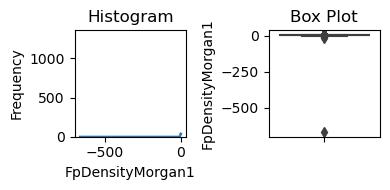

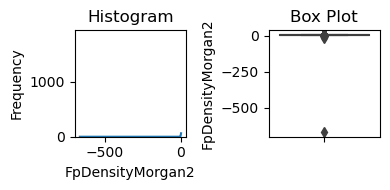

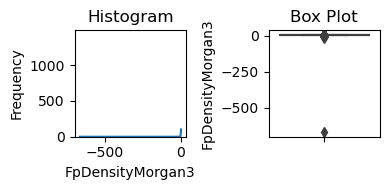

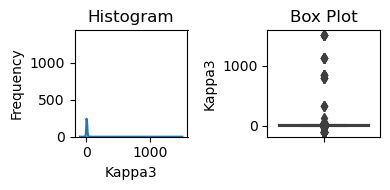

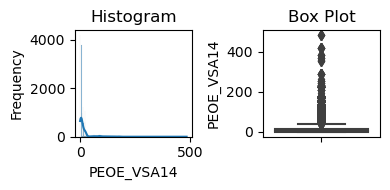

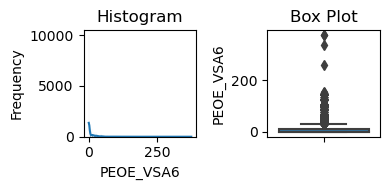

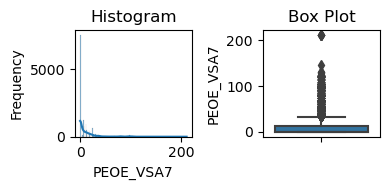

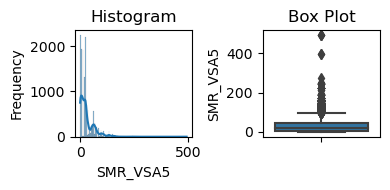

In [5]:
import seaborn as sns
skewed_features = ds[(ds['kurt'].abs())>10].index.tolist()


# Perform univariate analysis for each variable
for variable in skewed_features:
    plt.figure(figsize=(4, 2))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_train, x=variable, kde=True)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("Histogram")
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_train, y=variable)
    plt.ylabel(variable)
    plt.title("Box Plot")
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plots
    plt.show()

### Feature Importance
Since data is heavily skewed we use RandomForest instead of correlation to know important features

In [6]:
# Separate the features (X) and the target variable (y) for EC1
X = df_train.drop(['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6','id'], axis=1)  
y_ec1 = df_train['EC1']
y_ec2 = df_train['EC2']

clf_ec1 = RandomForestClassifier(random_state = RANDOM_STATE)
clf_ec1.fit(X, y_ec1)

clf_ec2 = RandomForestClassifier(random_state = RANDOM_STATE)
clf_ec2.fit(X, y_ec2)

results_ec1 = pd.DataFrame({'Feature': X.columns, 'Importance': clf_ec1.feature_importances_})
results_ec1 = results_ec1.reindex(results_ec1['Importance'].abs().sort_values(ascending=False).index)
display(results_ec1)

results_ec2 = pd.DataFrame({'Feature': X.columns, 'Importance': clf_ec2.feature_importances_})
results_ec2 = results_ec2.reindex(results_ec2['Importance'].abs().sort_values(ascending=False).index)
display(results_ec2)

# Combined top 10 features from both
df_merge = pd.merge(results_ec1.head(10), results_ec2.head(10),on='Feature',how="outer")
display(df_merge)

,Feature,Importance
18,MinEStateIndex,0.051
17,MaxAbsEStateIndex,0.044
8,EState_VSA1,0.043
5,Chi2v,0.040
16,Kappa3,0.040
28,VSA_EState9,0.040
0,BertzCT,0.040
19,NumHeteroatoms,0.039
3,Chi1v,0.038
10,ExactMolWt,0.038


,Feature,Importance
18,MinEStateIndex,0.046
17,MaxAbsEStateIndex,0.046
28,VSA_EState9,0.045
0,BertzCT,0.045
16,Kappa3,0.044
6,Chi3v,0.042
7,Chi4n,0.042
4,Chi2n,0.041
3,Chi1v,0.041
5,Chi2v,0.041


,Feature,Importance_x,Importance_y
0,MinEStateIndex,0.051,0.046
1,MaxAbsEStateIndex,0.044,0.046
2,EState_VSA1,0.043,NaN
3,Chi2v,0.040,0.041
4,Kappa3,0.040,0.044
5,VSA_EState9,0.040,0.045
6,BertzCT,0.040,0.045
7,NumHeteroatoms,0.039,NaN
8,Chi1v,0.038,0.041
9,ExactMolWt,0.038,NaN


### Train vs Test Distribution

In [7]:
columns = ['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v',
       'Chi3v', 'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
       'HallKierAlpha', 'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex',
       'MinEStateIndex', 'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14',
       'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5',
       'SlogP_VSA3', 'VSA_EState9', 'fr_COO', 'fr_COO2']
# Create DataFrame for the feature distributions
df_dist= pd.DataFrame(columns=['Feature'
                               , 'Train Mean'
                               , 'Test Mean'
                               , 'Train Variance'
                               , 'Test Variance'
                               , 'Train Median'
                               , 'Test Median'
                               , 'Train Stdev'
                               , 'Test Stdev'
                               , 'KS_Statistic'
                               , 'p-value'])


# Iterate over the features to compare their distributions
for feature in columns:
    # Calculate descriptive statistics
    train_mean = np.mean(df_train[feature])
    train_variance = np.var(df_train[feature])
    train_median = np.median(df_train[feature])
    train_stdev = np.std(df_train[feature])

    test_mean = np.mean(df_test[feature])
    test_variance = np.var(df_test[feature])
    test_median = np.median(df_test[feature])
    test_stdev = np.std(df_test[feature])

    # Perform Kolmogorov-Smirnov test
    ks_stat, p_value = ks_2samp(df_train[feature], df_test[feature])

    # Store the results in the DataFrame
    df_dist = df_dist.append({'Feature': feature
                              , 'Train Mean': train_mean
                              , 'Test Mean': test_mean
                              , 'Train Variance': train_variance
                              , 'Test Variance': test_variance
                              , 'Train Median': train_median
                              , 'Test Median': test_median
                              , 'Train Stdev': train_stdev
                              , 'Test Stdev': test_stdev
                              , 'KS_Statistic': ks_stat
                              , 'p-value': p_value}
                             , ignore_index=True)
# Display the results
display(df_dist)

,Feature,Train Mean,Test Mean,Train Variance,Test Variance,Train Median,Test Median,Train Stdev,Test Stdev,KS_Statistic,p-value
0,BertzCT,515.154,516.412,"294,239.082","296,262.799",290.988,289.902,542.438,544.300,0.009,0.717
1,Chi1,9.135,9.107,46.509,45.620,6.485,6.447,6.820,6.754,0.008,0.783
2,Chi1n,5.854,5.848,21.594,21.543,4.053,4.010,4.647,4.641,0.008,0.788
3,Chi1v,6.738,6.734,34.413,34.382,4.393,4.338,5.866,5.864,0.009,0.673
4,Chi2n,4.433,4.429,14.141,14.212,2.970,2.930,3.760,3.770,0.010,0.634
5,Chi2v,5.253,5.248,24.255,24.398,3.243,3.168,4.925,4.939,0.010,0.548
6,Chi3v,3.419,3.401,11.807,11.776,1.949,1.924,3.436,3.432,0.008,0.811
7,Chi4n,1.773,1.750,3.481,3.375,1.073,1.059,1.866,1.837,0.011,0.509
8,EState_VSA1,29.203,28.956,"1,006.641",990.315,17.354,17.282,31.728,31.469,0.009,0.655
9,EState_VSA2,10.435,10.535,186.360,189.542,6.421,6.421,13.651,13.767,0.006,0.993


#### 📝 Observation
No major distribution difference between test and training data. p-values are mostly above 0.05 and the statistics measurements relatively similar. 

## 🕵 Problem Definition<a class="anchor"  id="s4"></a>

In [8]:
target = ['EC1','EC2']
display(pd.concat([df_train[target].value_counts(),df_train[target].value_counts(normalize=True)], axis = 1, keys = ["Count","Pct"] ))

,,Count,Pct
EC1,EC2,,
1,1,7507,0.506
0,1,4348,0.293
1,0,2401,0.162
0,0,582,0.039


##### 📝 Overview
`1` From the above, we noticed that a row can have two class, EC1 and EC2. This indicate that the problem is a **multi-label** and not a **multi-class** problem (a row can only belong to one category, i.e. EC1 or EC2).  This will affect the model selection for the machine learning. <br/>
> As an implication, there are 2 ways this problem can be approached, <mark> (1) creating 2 different models for EC1, and EC2 or (2) Use Multi-label model classification such as : **Binary Relevance, Label Power Set, and Classifier Chain**</mark><br/>For this analysis, I will be using the second approach as it  allows for a more streamlined and unified modeling process. It considers the dependencies between labels and avoids the need to train separate models for each label. I will also focusing on trees and bossting models such as : <mark>Decision Tree (as a baseline), Random Forest, XGB, AdaBoost, CatBoost for the classifier</mark>. Using multi-label classification because xxx

`2` When we look into the `Percentage` column, we can clearly see that the class is **imbalance**. almost 50% of the observation are both EC1 and EC whereas the minority class, particularly non-EC1 and non-EC2 only accounts for 3% of the train data
> As an implication, we need to balance the class during training trough <mark>under-sampling, over-sampling, or generating synthetic data</mark>. For this analysis, we will choose <b><mark>SMOTE</mark></b> techniques. Note that SMOTE is not naturally created for Multi-label classification, therefore, we need to tweak the approach slightly, as can be seen in section 5

## 🧑‍🍳️  Data Preparation<a class="anchor"  id="s5"></a>

Split class between train and development. Then generate synthetic data to balance the class. Since we are using tree and bossting model, we don't necessarily need to scale the data as tree models are not sensitive to the variance of the data. 

In [9]:
drop = ["id","EC1", "EC2","EC3","EC4","EC5","EC6"]
target = ["EC1","EC2"]

X = df_train.drop(columns = drop)
y = df_train[target]

X_train, X_dev, y_train, y_dev = train_test_split(X, y,  test_size=0.2, random_state=RANDOM_STATE)

print("Data Class Proportion")
display(pd.concat([y.value_counts(),y.value_counts(normalize=True)], axis = 1, keys = ["Count","Pct"] ))

print("Train Data Class Proportion")
display(pd.concat([y_train.value_counts(),y_train.value_counts(normalize=True)], axis = 1, keys = ["Count","Pct"] ))

print("Dev Data Class Proportion")
display(pd.concat([y_dev.value_counts(),y_dev.value_counts(normalize=True)], axis = 1, keys = ["Count","Pct"] ))

Data Class Proportion


,,Count,Pct
EC1,EC2,,
1,1,7507,0.506
0,1,4348,0.293
1,0,2401,0.162
0,0,582,0.039


Train Data Class Proportion


,,Count,Pct
EC1,EC2,,
1,1,5983,0.504
0,1,3472,0.293
1,0,1933,0.163
0,0,482,0.041


Dev Data Class Proportion


,,Count,Pct
EC1,EC2,,
1,1,1524,0.513
0,1,876,0.295
1,0,468,0.158
0,0,100,0.034


## 🏋 Train Model<a class="anchor"  id="s6"></a>


In [10]:
dt = MultiOutputClassifier(DecisionTreeClassifier())
dt.fit(X_train, y_train)

rf = MultiOutputClassifier(RandomForestClassifier())
rf.fit(X_train, y_train)

ab = MultiOutputClassifier(AdaBoostClassifier())
ab.fit(X_train, y_train)

gb = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=28, learning_rate=0.055,min_samples_leaf=10,random_state=42))
gb.fit(X_train, y_train)

cb = MultiOutputClassifier(CatBoostClassifier(random_state=RANDOM_STATE,n_estimators=50, learning_rate=0.1, verbose=False,auto_class_weights='Balanced'))
cb.fit(X_train, y_train)

xgb = MultiOutputClassifier(XGBClassifier(random_state=RANDOM_STATE, eval_metric='auc'))
xgb.fit(X_train, y_train)

lgb = MultiOutputClassifier(LGBMClassifier(random_state=RANDOM_STATE, is_unbalance=True, metric='auc'))
lgb.fit(X_train, y_train)

hgb = MultiOutputClassifier(HistGradientBoostingClassifier(learning_rate=0.15,random_state=42,n_iter_no_change=4,min_samples_leaf=19,max_leaf_nodes = 3,max_bins=225,class_weight='balanced'))
hgb.fit(X_train, y_train)


MultiOutputClassifier(estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                               learning_rate=0.15,
                                                               max_bins=225,
                                                               max_leaf_nodes=3,
                                                               min_samples_leaf=19,
                                                               n_iter_no_change=4,
                                                               random_state=42))

## ✍️ Evaluate Model<a class="anchor"  id="s7"></a>

In [11]:
# Table with f1, ROC-AUC, AP Mean Score
# Evaluation metrics

def evaluate(classifier):
    scores = cross_validate(classifier, X_dev, y_dev, cv=10, scoring = ['roc_auc','average_precision'], )
    print('ROC-AUC Mean Score : {:.4f}'.format(scores['test_roc_auc'].mean()))
    print('AP Mean Score : {:.4f}'.format(scores['test_average_precision'].mean()))

models = [dt, rf, ab, gb, cb, xgb, lgb, hgb]
model_names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'CatBoost', 'XGBoost', 'LGBoost', 'HistGB']
dic_score_list = []


for i,model in  enumerate(models):
    scores = cross_validate(model, X_dev, y_dev, cv=10, scoring = ['roc_auc','average_precision'])
    dic_score_list.append({'Model':model_names[i],'ROC-AUC':scores['test_roc_auc'].mean(),'AP':scores['test_average_precision'].mean() })

df_scores = pd.DataFrame.from_dict(dic_score_list)
display(df_scores)

,Model,ROC-AUC,AP
0,Decision Tree,0.535,0.756
1,Random Forest,0.628,0.827
2,AdaBoost,0.629,0.820
3,Gradient Boosting,0.646,0.827
4,CatBoost,0.642,0.829
5,XGBoost,0.607,0.813
6,LGBoost,0.614,0.818
7,HistGB,0.635,0.824


##### 7.2.  AUC ROC Curve

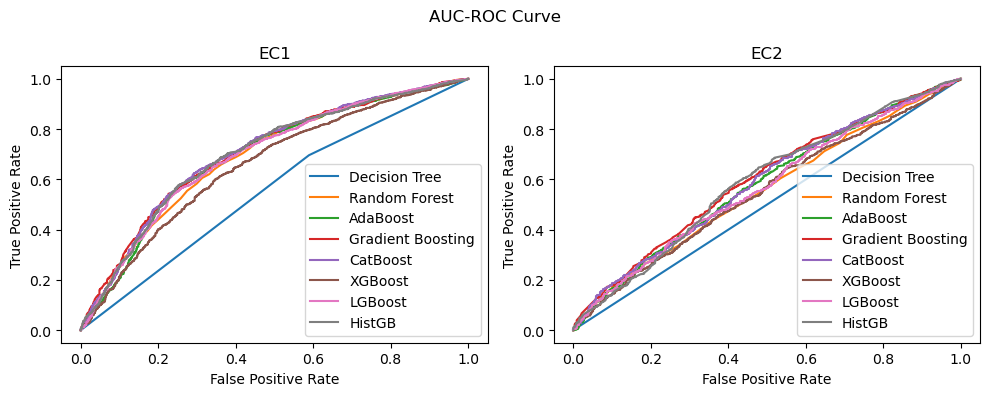

In [12]:
# AUC ROC Curve
class_names = ["EC1","EC2"]

plt.figure(figsize = (10, 4))
plt.plot([1, 2, 2])

for j,class_name in enumerate(class_names):
    ax = plt.subplot(1,2,j+1)
    for i,model in  enumerate(models):
        fpr, tpr, thresholds = roc_curve(y_dev.iloc[:,j], model.predict_proba(X_dev)[j][:,1])
        ax.plot(fpr,tpr, label = model_names[i])
    ax.set_title(class_name)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

plt.suptitle("AUC-ROC Curve")
plt.tight_layout()
plt.show()

In [13]:
df_submission.iloc[:,1:] = np.array(gb.predict_proba(X_submission))[:,:,1].T
df_submission.to_csv("submission_gb.csv", index=False)
# Public score .63822

## 🧪 Experiment
##### 8.1. Voting

In [14]:
voting = MultiOutputClassifier(
    VotingClassifier(estimators = [
        ('hb',HistGradientBoostingClassifier(learning_rate=0.15,random_state=42,n_iter_no_change=4,min_samples_leaf=19,max_leaf_nodes = 3,max_bins=225))
        ,('gb',GradientBoostingClassifier(n_estimators=28, learning_rate=0.055,min_samples_leaf=10,random_state=42))
        ,('cb',CatBoostClassifier(n_estimators=50, learning_rate=0.1, verbose=False))
    ], voting = 'soft'))
voting.fit(X_train, y_train)
evaluate(voting)


ROC-AUC Mean Score : 0.6470
AP Mean Score : 0.8299


In [15]:
# Submission
df_submission.iloc[:,1:] = np.array(voting.predict_proba(X_submission))[:,:,1].T
df_submission.to_csv("submission_voting.csv", index=False)
# Public score .64226

##### 8.2. Exp 2: ClassifierChain + Catboost

In [16]:
cb_cc = ClassifierChain(
    classifier = CatBoostClassifier(n_estimators=50, learning_rate=0.1, verbose=False),
    require_dense = [False, True]
)

# train
cb_cc.fit(X_train, y_train)

# predict
roc_auc_score(y_dev,cb_cc.predict_proba(X_dev).toarray())

0.643923941371292

In [17]:
# Submission

df_submission.iloc[:,1:] = np.array(cb_cc.predict_proba(X_submission).toarray())
df_submission.to_csv("submission_lp.csv", index=False)
# Public score .64032

##### 8.3. Regression

In [18]:
# EC1
dic_ec1_train = {
    'hgb':np.array(hgb.predict_proba(X_train))[:,:,1][0]
    , 'gb': np.array(gb.predict_proba(X_train))[:,:,1][0]
    #, 'cb': np.array(cb.predict_proba(X_train))[:,:,1][0]
}
X_train_ec1 = pd.DataFrame.from_dict(dic_ec1_train)
y_train_ec1 = y_train['EC1']

logistic_model_ec1 = LogisticRegression()
logistic_model_ec1.fit(X_train_ec1, y_train_ec1)
#ec1_coeff = np.ravel(logistic_model_ec1.coef_)
#print("EC1 coeff",ec1_coeff)

# EC2
dic_ec2_train = {
    'hgb':np.array(hgb.predict_proba(X_train))[:,:,1][1]
    ,'gb': np.array(gb.predict_proba(X_train))[:,:,1][1]
    #, 'cb': np.array(cb.predict_proba(X_train))[:,:,1][1]
}
X_train_ec2 = pd.DataFrame.from_dict(dic_ec2_train)
y_train_ec2 = y_train['EC2']

logistic_model_ec2 =  LogisticRegression()
logistic_model_ec2.fit(X_train_ec2, y_train_ec2)
#ec2_coeff = np.ravel(logistic_model_ec2.coef_)
#print("EC2 coeff",ec2_coeff)

LogisticRegression()

In [19]:
dic_ec1_dev = {
    'hgb':np.array(hgb.predict_proba(X_dev))[:,:,1][0]
    , 'gb': np.array(gb.predict_proba(X_dev))[:,:,1][0]
    #, 'cb': np.array(cb.predict_proba(X_dev))[:,:,1][0]
}
ec1_dev_pred = logistic_model_ec1.predict_proba(pd.DataFrame.from_dict(dic_ec1_dev))
print(roc_auc_score(np.ravel(y_dev['EC1']), ec1_dev_pred[:,1]))

dic_ec2_dev = {
    'hgb':np.array(hgb.predict_proba(X_dev))[:,:,1][1]
    ,'gb': np.array(gb.predict_proba(X_dev))[:,:,1][1]
    #, 'cb': np.array(cb.predict_proba(X_dev))[:,:,1][1]
}
ec2_dev_pred = logistic_model_ec2.predict_proba(pd.DataFrame.from_dict(dic_ec2_dev))
print(roc_auc_score(np.ravel(y_dev['EC2']), ec2_dev_pred[:,1]))

0.7030565911185727
0.5945118104460093


In [20]:
# submission 
df = df_test.copy().drop(columns=['id'])
dic_ec1_test = {
    'hgb':np.array(hgb.predict_proba(df))[:,:,1][0]
    , 'gb': np.array(gb.predict_proba(df))[:,:,1][0]
    #, 'cb': np.array(cb.predict_proba(df))[:,:,1][0]
}
ec1_test_pred = logistic_model_ec1.predict_proba(pd.DataFrame.from_dict(dic_ec1_test))[:,1]

dic_ec2_test = {
    'hgb':np.array(hgb.predict_proba(df))[:,:,1][1]
    , 'gb': np.array(gb.predict_proba(df))[:,:,1][1]
    #, 'cb': np.array(cb.predict_proba(df))[:,:,1][1]
}
ec2_test_pred = logistic_model_ec2.predict_proba(pd.DataFrame.from_dict(dic_ec2_test))[:,1]

In [21]:
df_submission.iloc[:,1] = ec1_test_pred
df_submission.iloc[:,2] = ec2_test_pred
df_submission.to_csv("submission_lr.csv", index=False)
# Public score .6414

## 🎯 Conclusion <a class="anchor"  id="9"></a>

## 👀 Reference<a class="anchor"  id="9"></a>

##### 📝 Overview
 <b><mark style="background-color:#000000;color:white;border-radius:5px;opacity:1.0"> Observation </mark></b><br/>
  <b><mark style="background-color:#000000;color:white;border-radius:5px;opacity:1.0">Implication</mark></b><br/>